<a href="https://colab.research.google.com/github/DanisGaleev/FakeFaceChecker/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload() #json файл из личного кабинета kaggle для скачивания датасета

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [ ]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces
! unzip 140k-real-and-fake-faces.zip

In [ ]:
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install opencv-python
!pip install tensorflow
!pip install keras
!pip install scikit-learn

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import *
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 128
CHANNELS = 3
train_size = 10000
test_size = 8000
gpus = tf.config.list_physical_devices('GPU')

In [ ]:
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img, dtype='float32')
    img = img / 255
    return img

In [ ]:
labels = ['real', 'fake']

X = []
y = []

# labels -
# 0 - Real
# 1 - Fake
image_path = '//content//real_vs_fake//real-vs-fake//train//'

In [ ]:
s = 0
c = 0
X = np.empty((train_size, 128, 128, 3))
y = np.empty(train_size)
for folder in os.scandir(image_path):
  for entry in os.scandir(image_path + folder.name):
    X[c] = read_and_preprocess(image_path + folder.name + '/' + entry.name)
    if folder.name[0] == 'r':
        y[c] = 0 # real
    else:
        y[c] = 1 # fake
    s += 1
    c += 1
    if s == train_size // 2:
      s = 0
      break
print(X.shape, y.shape)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=123)
del X, y
print(X_train.shape, y_train.shape, y_train[:200])

(8000, 128, 128, 3) (8000,) array([1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D((4,4)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(192, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights2.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
with tf.device("/device:GPU:1"):
    history = model.fit(X_train, y_train, epochs = 15, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/15
63/63 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.5411
Epoch 1: val_accuracy improved from -inf to 0.58500, saving model to fakevsreal_weights.h5
63/63 [==============================] - 13s 86ms/step - loss: 0.6879 - accuracy: 0.5411 - val_loss: 0.6710 - val_accuracy: 0.5850
Epoch 2/15
 2/63 [..............................] - ETA: 3s - loss: 0.6612 - accuracy: 0.5938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/63 [============================>.] - ETA: 0s - loss: 0.6482 - accuracy: 0.6177
Epoch 2: val_accuracy improved from 0.58500 to 0.68300, saving model to fakevsreal_weights.h5
63/63 [==============================] - 3s 50ms/step - loss: 0.6482 - accuracy: 0.6176 - val_loss: 0.6149 - val_accuracy: 0.6830
Epoch 3/15
62/63 [============================>.] - ETA: 0s - loss: 0.5852 - accuracy: 0.6907
Epoch 3: val_accuracy did not improve from 0.68300
63/63 [==============================] - 3s 56ms/step - loss: 0.5844 - accuracy: 0.6916 - val_loss: 0.5946 - val_accuracy: 0.6805
Epoch 4/15
63/63 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.7354
Epoch 4: val_accuracy improved from 0.68300 to 0.74950, saving model to fakevsreal_weights.h5
63/63 [==============================] - 3s 51ms/step - loss: 0.5238 - accuracy: 0.7354 - val_loss: 0.5074 - val_accuracy: 0.7495
Epoch 5/15
63/63 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.7626
Epoch 

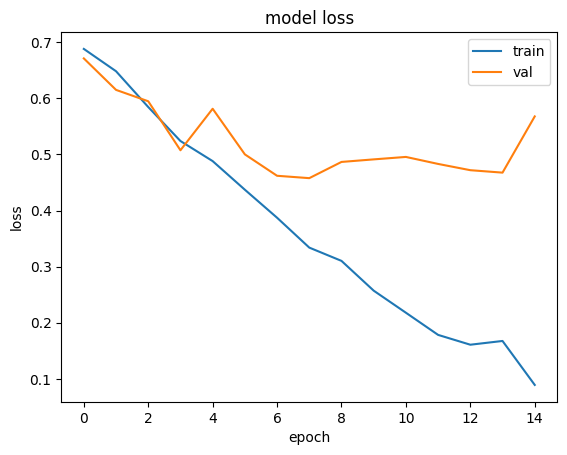

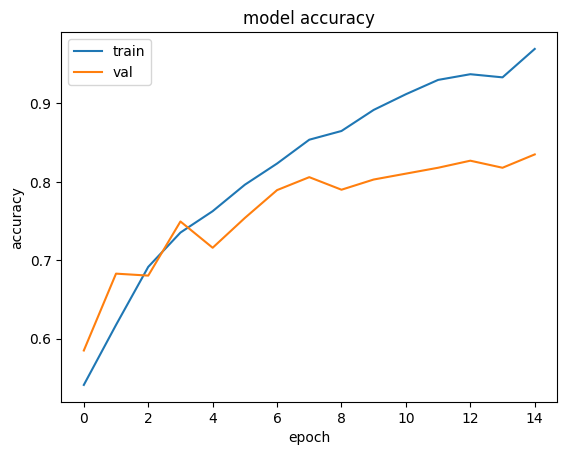

In [ ]:
model_json = model.to_json()
with open("fakevsreal_model2.json","w") as json_file:
  json_file.write(model_json)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_test = np.empty((test_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
y_test = np.empty(test_size)
image_path = '//content//real_vs_fake//real-vs-fake//test//'
c = 0
s = 0
# for folder in os.scandir(image_path):
#   for entry in os.scandir(image_path + folder.name):
#     if folder.name[0] == 'f':
#       X_test[c] = read_and_preprocess(image_path + folder.name + '/' + entry.name)
#       print(image_path + folder.name + '/' + entry.name)
#       if folder.name[0] == 'f':
#           y_test[c] = 1 # real
#       s += 1
#       c += 1
#       if c == test_size:
#         break
# print(y_test[:200])
for folder in os.scandir(image_path):
  for entry in os.scandir(image_path + folder.name):
    X_test[c] = read_and_preprocess(image_path + folder.name + '/' + entry.name)
    # print(image_path + folder.name + '/' + entry.name)
    if folder.name[0] == 'r':
        y_test[c] = 0 # real
    else:
        y_test[c] = 1 # fake
    s += 1
    c += 1

    if s == test_size // 2:
      s = 0
      break


In [ ]:
model = tf.keras.models.load_model('/content/fakevsreal_weights2.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [ ]:
predictions = model.predict(X_test)
print(model.evaluate(X_test, y_test))

250/250 [==============================] - 2s 6ms/step - loss: 0.5663 - accuracy: 0.8216
[0.5662536025047302, 0.8216249942779541]


In [ ]:
predict = []

for i in predictions:
  predict.append(np.argmax(i))
  print(np.argmax(i))

predict = np.asarray(predict)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.821625

<Axes: >

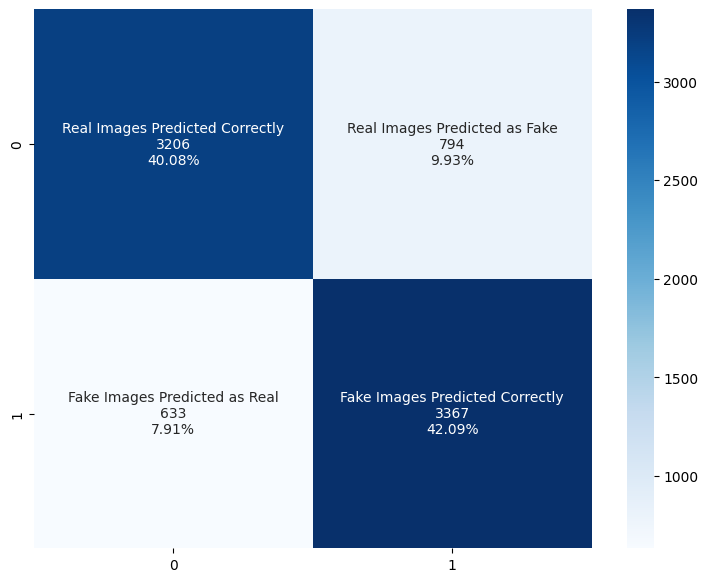

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize = (9,7))

group_names = ['Real Images Predicted Correctly','Real Images Predicted as Fake','Fake Images Predicted as Real','Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

         0.0       0.84      0.80      0.82      4000
         1.0       0.81      0.84      0.83      4000

    accuracy                           0.82      8000
   macro avg       0.82      0.82      0.82      8000
weighted avg       0.82      0.82      0.82      8000



In [ ]:
pip install "google-cloud-aiplatform>=1.38"

In [ ]:
# TODO(developer): Vertex AI SDK - uncomment below & run
# pip3 install --upgrade --user google-cloud-aiplatform
# gcloud auth application-default login

import vertexai
from vertexai.generative_models import GenerativeModel, Part


def generate_text(project_id: str, location: str) -> str:
    # Initialize Vertex AI
    vertexai.init(project=project_id, location=location)
    # Load the model
    multimodal_model = GenerativeModel("gemini-1.0-pro-vision")
    # Query the model
    response = multimodal_model.generate_content(
        [
            # Add an example image
            Part.from_uri(
                "gs://generativeai-downloads/images/scones.jpg", mime_type="image/jpeg"
            ),
            # Add an example query
            "what is shown in this image?",
        ]
    )
    print(response)
    return response.text
generate_text()
